In [1]:
import glob, re, os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [5]:
sp_pattern = re.compile('SAO PAULO - MIRANTE')
sp_files = [file for file in glob.glob(f'data/*') if sp_pattern.search(file)]

sp_files

['data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2023_A_30-11-2023.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2011_A_31-12-2011.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2009_A_31-12-2009.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2019_A_31-12-2019.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_25-07-2006_A_31-12-2006.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2010_A_31-12-2010.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2015_A_31-12-2015.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2014_A_31-12-2014.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2012_A_31-12-2012.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2007_A_31-12-2007.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2018_A_31-12-2018.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2020_A_31-12-2020.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2013_A_31-12-2013.CSV',
 'data/INMET_SE_SP_A701_SAO PAULO - MI

In [6]:
# fixing byte error
for sp_file in sp_files:
    with open(sp_file, 'r') as f:
        content = f.read()
    with open(sp_file, 'w', encoding='utf-8') as f:
        f.write(content)

<Axes: xlabel='datetime'>

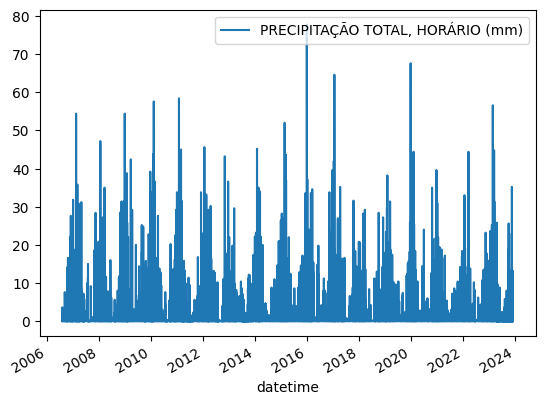

In [15]:
dfs = []
col_names = None
for sp_file in sp_files:
    res = pd.read_csv(sp_file, sep=';', skiprows=8, decimal=',', encoding='utf-8')
    time = pd.to_datetime(res[res.columns[:2]].apply(lambda row: row.str.cat(sep='T'), axis=1), utc=True)
    res = res[res.columns[2:]].set_index(pd.Index(time, name='datetime'))
    res = res.replace(-9999, np.nan)
 
    dfs.append(res)
    
df = pd.concat(dfs, axis=0).sort_index()
df = df[~((df.index.day == 29) & (df.index.month == 2))]
df[df.columns[:1]].plot()

In [21]:
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19,RADIACAO GLOBAL (KJ/m²)
datetime,,,,,,,,,,,,,,,,,,,
2006-07-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-25 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-25 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-25 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-25 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 19:00:00+00:00,0.0,921.7,922.0,921.7,1795.8,29.1,17.7,30.2,28.6,18.3,16.8,52.0,46.0,50.0,335.0,9.0,3.6,NaN,NaN
2023-11-30 20:00:00+00:00,0.0,921.7,921.7,921.5,791.9,28.1,19.5,29.6,28.1,19.5,17.2,60.0,49.0,60.0,242.0,6.8,2.0,NaN,NaN
2023-11-30 21:00:00+00:00,0.0,922.3,922.3,921.7,65.2,26.7,20.2,28.1,26.7,20.2,19.6,68.0,60.0,68.0,229.0,6.6,2.2,NaN,NaN


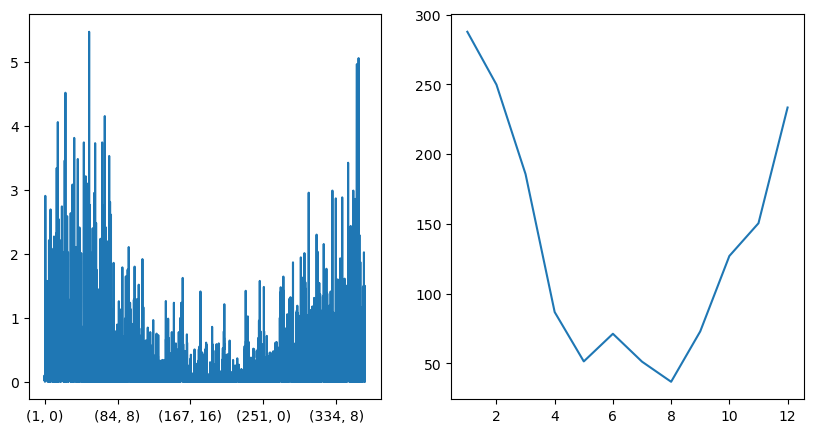

In [137]:
prec_base = df[df.columns[:1]] # - df[df.columns[:1]].mean()
prec_year = prec_base.groupby([prec_base.index.day_of_year, prec_base.index.hour]).mean()

# arr = prec_year.values.ravel()
# for _ in range(300): arr = np.correlate(np.pad(arr, (1, 1), 'reflect'), [0.25, 0.5, 0.25])

fig, axs = plt.subplots(1, 2, figsize=(10., 5.))
prec_year.plot(ax=axs[0])

prec_month = df[df.columns[:1]].groupby(pd.Grouper(freq='M')).sum()
prec_month.groupby([prec_month.index.month]).mean().plot(ax=axs[1])

axs[0].get_legend().remove()
axs[1].get_legend().remove()

# axs[0].xaxis.set_major_formatter(lambda x, pos: prec_year.index[int(x)])

<Axes: >

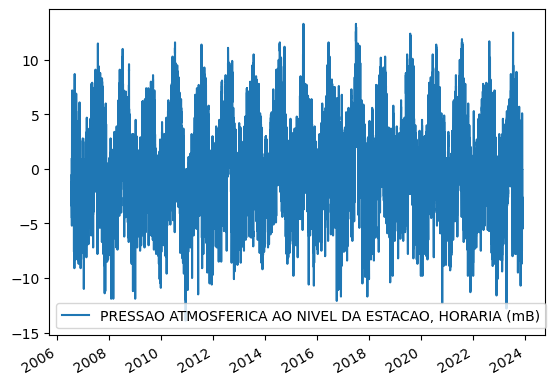

In [140]:
df[df.columns[1:2]] - df[df.columns[1:2]].mean()
